# MLP for NLP Classification
Reference Docs:
- https://colab.research.google.com/drive/1WUy4G2SsoLelrZDkO2I0v9tHx9x27NJK?usp=sharing

### Imports and Settings

In [78]:
%load_ext autoreload
%autoreload 2

import os, gc
import numpy as np
import random
from tqdm import tqdm
import torch
%matplotlib inline

import json
import torch

with open ('../settings.json') as f:
    settings = json.load(f)

DATA_DIR = os.path.join(settings['data_path'], 'classifier')
os.makedirs(DATA_DIR, exist_ok=True)
CHECKPOINT_DIR = os.path.join(DATA_DIR, "model_data")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_PREFIX = os.path.join(CHECKPOINT_DIR, "mlp4mal-test")

RANDOM_SEED = 4444
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCABULARY_SIZE = 20000
DROPOUT = 0.25
LEARNING_RATE = 1e-3
EMBEDDING_DIM = 128
BATCH_SIZE = 32
NUM_EPOCHS = 15
NUM_CLASSES = 4
MAX_LENGTH = 20480 * 2
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up CUDA debug environment

In [79]:
# Enable synchronous CUDA execution for better error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Enable device-side assertions in CUDA kernels
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Confirm the variables are set
print("CUDA_LAUNCH_BLOCKING =", os.getenv('CUDA_LAUNCH_BLOCKING'))
print("TORCH_USE_CUDA_DSA =", os.getenv('TORCH_USE_CUDA_DSA'))

CUDA_LAUNCH_BLOCKING = 1
TORCH_USE_CUDA_DSA = 1


### Load Data (already cleaned and selected)

In [80]:
from datasets import load_dataset

REPORT_DIR = os.path.join(DATA_DIR, "report_data")
os.makedirs(REPORT_DIR, exist_ok=True)

# get all files in the report directory
file_paths = [os.path.join(REPORT_DIR, f) for f in os.listdir(REPORT_DIR) if os.path.isfile(os.path.join(REPORT_DIR, f))]
print(file_paths)

dataset = load_dataset('json', data_files=file_paths)['train']
print(dataset)
# get 1000 random samples
dataset = dataset.shuffle(seed=RANDOM_SEED)
dataset = dataset.select(list(range(1000)))
print(dataset)

['/media/mike/data/gimc/classifier/report_data/json_0.json', '/media/mike/data/gimc/classifier/report_data/json_1.json', '/media/mike/data/gimc/classifier/report_data/json_10.json', '/media/mike/data/gimc/classifier/report_data/json_11.json', '/media/mike/data/gimc/classifier/report_data/json_12.json', '/media/mike/data/gimc/classifier/report_data/json_13.json', '/media/mike/data/gimc/classifier/report_data/json_14.json', '/media/mike/data/gimc/classifier/report_data/json_15.json', '/media/mike/data/gimc/classifier/report_data/json_2.json', '/media/mike/data/gimc/classifier/report_data/json_3.json', '/media/mike/data/gimc/classifier/report_data/json_4.json', '/media/mike/data/gimc/classifier/report_data/json_5.json', '/media/mike/data/gimc/classifier/report_data/json_6.json', '/media/mike/data/gimc/classifier/report_data/json_7.json', '/media/mike/data/gimc/classifier/report_data/json_8.json', '/media/mike/data/gimc/classifier/report_data/json_9.json']
Dataset({
    features: ['text', 

### Split Data

In [81]:
# First, split into 40% train and 20% (validation + test), with shuffling
train_test_split = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_dataset = train_test_split['train']
temp_dataset = train_test_split['test']

# Then, split the 20% temp_dataset into 10% validation and 10% test, with shuffling
validation_test_split = temp_dataset.train_test_split(test_size=0.5, seed=42, shuffle=True)
validation_dataset = validation_test_split['train']
test_dataset = validation_test_split['test']

# Check the size and order of samples in each split
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(validation_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


Train dataset: 800 samples
Validation dataset: 100 samples
Test dataset: 100 samples


### Load Tokenizer

In [82]:
tokenizer_path = os.path.join(DATA_DIR, 'model_data', 'mal-reformer')
print(f"Tokenizer path: {tokenizer_path}")

import torch
from transformers import AutoTokenizer, ReformerForSequenceClassification

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
tokenizer.pad_token = "[PAD]"
tokenizer.cls_token = "[CLS]"
tokenizer.sep_token = "[SEP]"

Tokenizer path: /media/mike/data/gimc/classifier/model_data/mal-reformer


### Tokenizer Function

In [83]:
def tokenize_function(example):
    return tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

In [84]:
# Tokenize each split
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

### Create Dataloaders

In [85]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,SequentialSampler)

def data_loader(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE):
    train_inputs, val_inputs, test_inputs = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    
    for i in tqdm(range(len(train_dataset)), desc="Tokenizing train dataset"):
        train_inputs.append(train_dataset[i]['input_ids'])
        train_labels.append(train_dataset[i]['label'])
    for i in tqdm(range(len(val_dataset)), desc="Tokenizing validation dataset"):
        val_inputs.append(val_dataset[i]['input_ids'])
        val_labels.append(val_dataset[i]['label'])
    for i in tqdm(range(len(test_dataset)), desc="Tokenizing test dataset"):
        test_inputs.append(test_dataset[i]['input_ids'])
        test_labels.append(test_dataset[i]['label'])

    # Convert data type to torch.Tensor
    train_inputs = torch.tensor(train_inputs)
    val_inputs = torch.tensor(val_inputs)
    test_inputs = torch.tensor(test_inputs)
    train_labels = torch.tensor(train_labels)
    val_labels = torch.tensor(val_labels)
    test_labels = torch.tensor(test_labels)
                                   
    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    # create DataLoader for test data
    test_data = TensorDataset(test_inputs, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    return train_dataloader, val_dataloader, test_dataloader

In [86]:
train_dataloader, val_dataloader, test_dataloader = data_loader(tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset)

Tokenizing test dataset: 100%|██████████| 100/100 [00:04<00:00, 22.43it/s]


### Train Loop

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No checkpoint found at /media/mike/data/gimc/classifier/model_data/mlp4mal-test_checkpoint.pth. Start training from scratch.


Epoch: 001/015 | Train: 68.00% | Validation: 66.00% | Elapsed: 0.01 min


Epoch: 002/015 | Train: 67.38% | Validation: 65.00% | Elapsed: 0.02 min


Epoch: 003/015 | Train: 68.38% | Validation: 66.00% | Elapsed: 0.03 min


Epoch: 004/015 | Train: 86.25% | Validation: 80.00% | Elapsed: 0.05 min


Epoch: 005/015 | Train: 90.62% | Validation: 89.00% | Elapsed: 0.06 min


Epoch: 006/015 | Train: 92.38% | Validation: 92.00% | Elapsed: 0.08 min


Epoch: 007/015 | Train: 92.50% | Validation: 91.00% | Elapsed: 0.10 min


Epoch: 008/015 | Train: 91.50% | Validation: 90.00% | Elapsed: 0.13 min


Epoch: 009/015 | Train: 92.50% | Validation: 91.00% | Elapsed: 0.15 min


Epoch: 010/015 | Train: 92.50% | Validation: 91.00% | Elapsed: 0.18 min


Epoch: 011/015 | Train: 92.75% | Validation: 91.00% | Elapsed: 0.20 min


Epoch: 012/015 | Train: 92.50% | Validation: 91.00% | Elapsed: 0.23 min


Epoch: 013/015 | Train: 93.12% | Validation: 91.00% | Elapsed: 0.27 min


Epoch: 014/015 | Train: 92.88% | Validation: 91.00% | Elapsed: 0.30 min


Epoch: 015/015 | Train: 92.62% | Validation: 91.00% | Elapsed: 0.34 min
Total Training Time: 0.36 min


Test accuracy 93.00%


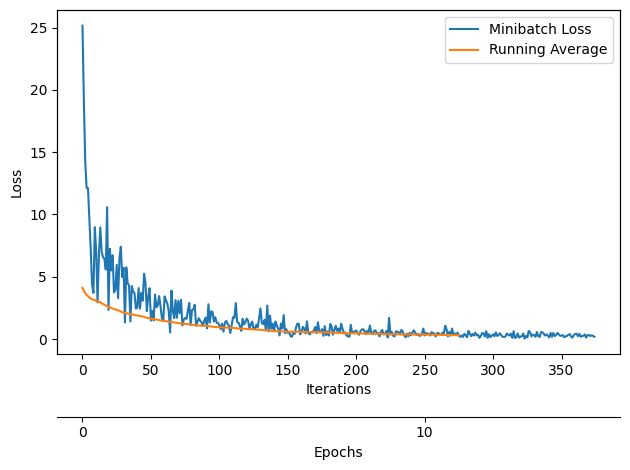

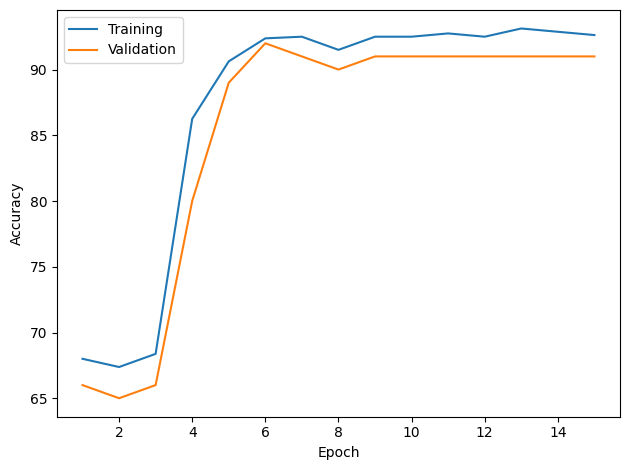

In [87]:
%load_ext autoreload
%autoreload 2
from utils.train import train_model
from utils.plot import plot_accuracy, plot_training_loss
from torch import optim
from models.mlp_nlp import MLP_NLP

model = MLP_NLP(vocab_size=VOCABULARY_SIZE,
                embed_dim=EMBEDDING_DIM,
                num_class=NUM_CLASSES,
                hidden_size1=513,
                hidden_size2=256,
                hidden_size3=128,
                dropout=DROPOUT)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

model = model.to(DEVICE)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_dataloader,
    valid_loader=val_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    checkpoint_prefix=CHECKPOINT_PREFIX,
    device=DEVICE,
    logging_interval=100,
    resume_on_epoch=2
)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_dataloader),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

### Sanity Check

In [88]:
# Create prediction function for raw text
def predict_text(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LENGTH).to(device)
    input_ids = inputs['input_ids']
    with torch.no_grad():
        logits = model(input_ids)
    return torch.argmax(logits, dim=-1).item()


In [89]:

for i in range(4):
    count = 0
    idx = i * 4
    with open(os.path.join(REPORT_DIR, f'json_{idx}.json')) as f:
        for line in f:
            data = json.loads(line)
            text = data['text']
            prediction = predict_text(text, model, tokenizer, DEVICE)
            print(f"label: {data['label']}, prediction: {prediction}")
            count += 1
            if count > 10:
                break

label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 1, prediction: 0
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 0
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 3, prediction: 3
label: 3, prediction: 3
label: 3, prediction: 3
label: 3, prediction: 3
label: 3, prediction: 3
label: 3, prediction: 3
label: 3, prediction: 3
label: 3, prediction: 3
label: 3, predic

In [90]:
checkpoint_path = "/media/mike/data/gimc/classifier/model_data/mlp4mal-test_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
print(checkpoint['epoch'])
print(len(checkpoint['train_acc_list']))
print(len(checkpoint['model_states']))

15
15
15
